In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)

# Try to import XGBoost
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print('XGBoost not available. Will compare available models only.')

# Set display options
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print('Libraries imported successfully')

Libraries imported successfully


## 1. Load Data and Prepare Train/Test Split

Use the same train/test split as all previous notebooks for fair comparison.

In [2]:
# Load features
PROCESSED = os.path.abspath(os.path.join('..', 'data', 'processed'))

# You can use either the original features or PCA-reduced features
USE_PCA_FEATURES = False  # Set to True to use PCA features

if USE_PCA_FEATURES:
    features_path = os.path.join(PROCESSED, 'features_pca.csv')
    print('Using PCA-reduced features')
else:
    features_path = os.path.join(PROCESSED, 'features.csv')
    print('Using original engineered features')

if not os.path.exists(features_path):
    print(f'ERROR: {features_path} not found')
else:
    df = pd.read_csv(features_path)
    print(f'Features loaded successfully')
    print(f'Dataset shape: {df.shape}')

Using original engineered features
Features loaded successfully
Dataset shape: (58817, 84)


In [3]:
# Identify target column
target_col = "Is_laundering"

if target_col in df.columns:
    print(f'Target column found: {target_col}')
    print(f'\nClass distribution:')
    print(df[target_col].value_counts())
    print(f'\nClass proportions:')
    print(df[target_col].value_counts(normalize=True))
else:
    print(f'ERROR: Target column "{target_col}" not found in dataset')
    print(f'Available columns: {df.columns.tolist()}')

Target column found: Is_laundering

Class distribution:
Is_laundering
0    49219
1     9598
Name: count, dtype: int64

Class proportions:
Is_laundering
0    0.836816
1    0.163184
Name: proportion, dtype: float64


In [4]:
# Define features and target
exclude_cols = [target_col, 'id', 'transaction_id', 'account_id', 'customer_id', 'Laundering_type', 'timestamp']
feature_cols = [col for col in df.columns if col not in exclude_cols]

X = df[feature_cols]
y = df[target_col]

print(f'Features shape: {X.shape}')
print(f'Target shape: {y.shape}')
print(f'\nNumber of features: {len(feature_cols)}')

Features shape: (58817, 82)
Target shape: (58817,)

Number of features: 82


In [5]:
# Stratified train/test split (same as all previous notebooks)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f'Training set: {X_train.shape[0]} samples')
print(f'Test set: {X_test.shape[0]} samples')

Training set: 47053 samples
Test set: 11764 samples


## 2. Train All Models

Train each model with their best configurations.

In [6]:
# Dictionary to store models and results
models = {}
results = []

### Model 1: Logistic Regression (Baseline)

In [7]:
print('Training Logistic Regression...')
lr_model = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
lr_model.fit(X_train, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:, 1]

# Store model
models['Logistic Regression'] = lr_model

# Calculate metrics
results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'F1 Score': f1_score(y_test, y_pred_lr),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_lr)
})

print('Logistic Regression complete.')

Training Logistic Regression...
Logistic Regression complete.


### Model 2: Decision Tree

In [8]:
print('Training Decision Tree...')
dt_model = DecisionTreeClassifier(random_state=42, max_depth=10, class_weight='balanced')
dt_model.fit(X_train, y_train)

# Predictions
y_pred_dt = dt_model.predict(X_test)
y_pred_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Store model
models['Decision Tree'] = dt_model

# Calculate metrics
results.append({
    'Model': 'Decision Tree',
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'Recall': recall_score(y_test, y_pred_dt),
    'F1 Score': f1_score(y_test, y_pred_dt),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_dt)
})

print('Decision Tree complete.')

Training Decision Tree...
Decision Tree complete.


### Model 3: Random Forest

In [9]:
print('Training Random Forest...')
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    random_state=42,
    class_weight='balanced',
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Store model
models['Random Forest'] = rf_model

# Calculate metrics
results.append({
    'Model': 'Random Forest',
    'Accuracy': accuracy_score(y_test, y_pred_rf),
    'Precision': precision_score(y_test, y_pred_rf),
    'Recall': recall_score(y_test, y_pred_rf),
    'F1 Score': f1_score(y_test, y_pred_rf),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_rf)
})

print('Random Forest complete.')

Training Random Forest...
Random Forest complete.


### Model 4: XGBoost (if available)

In [10]:
if XGBOOST_AVAILABLE:
    print('Training XGBoost...')
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        scale_pos_weight=scale_pos_weight,
        eval_metric='logloss'
    )
    xgb_model.fit(X_train, y_train)
    
    # Predictions
    y_pred_xgb = xgb_model.predict(X_test)
    y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]
    
    # Store model
    models['XGBoost'] = xgb_model
    
    # Calculate metrics
    results.append({
        'Model': 'XGBoost',
        'Accuracy': accuracy_score(y_test, y_pred_xgb),
        'Precision': precision_score(y_test, y_pred_xgb),
        'Recall': recall_score(y_test, y_pred_xgb),
        'F1 Score': f1_score(y_test, y_pred_xgb),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba_xgb)
    })
    
    print('XGBoost complete.')
else:
    print('XGBoost not available. Skipping.')

Training XGBoost...
XGBoost complete.


## 3. Complete Model Comparison Table

Display all metrics for all models in one comprehensive table.

In [11]:
# Create comparison dataframe
comparison_df = pd.DataFrame(results)

print('\n' + '=' * 95)
print('COMPLETE MODEL COMPARISON')
print('=' * 95)
print(comparison_df.to_string(index=False))
print('=' * 95)


COMPLETE MODEL COMPARISON
              Model  Accuracy  Precision   Recall  F1 Score  ROC-AUC
Logistic Regression  0.821914   0.468961 0.688542  0.557924 0.836195
      Decision Tree  0.919585   0.714537 0.844792  0.774224 0.941111
      Random Forest  0.938796   0.810238 0.816146  0.813181 0.962543
            XGBoost  0.926471   0.732481 0.865625  0.793507 0.966288


In [12]:
# Identify best models for each metric
print('\n' + '=' * 60)
print('BEST MODEL FOR EACH METRIC')
print('=' * 60)
print(f"Best Accuracy:  {comparison_df.loc[comparison_df['Accuracy'].idxmax(), 'Model']} ({comparison_df['Accuracy'].max():.4f})")
print(f"Best Precision: {comparison_df.loc[comparison_df['Precision'].idxmax(), 'Model']} ({comparison_df['Precision'].max():.4f})")
print(f"Best Recall:    {comparison_df.loc[comparison_df['Recall'].idxmax(), 'Model']} ({comparison_df['Recall'].max():.4f})")
print(f"Best F1 Score:  {comparison_df.loc[comparison_df['F1 Score'].idxmax(), 'Model']} ({comparison_df['F1 Score'].max():.4f})")
print(f"Best ROC-AUC:   {comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']} ({comparison_df['ROC-AUC'].max():.4f})")
print('=' * 60)


BEST MODEL FOR EACH METRIC
Best Accuracy:  Random Forest (0.9388)
Best Precision: Random Forest (0.8102)
Best Recall:    XGBoost (0.8656)
Best F1 Score:  Random Forest (0.8132)
Best ROC-AUC:   XGBoost (0.9663)


## 4. Visual Comparison - All Metrics

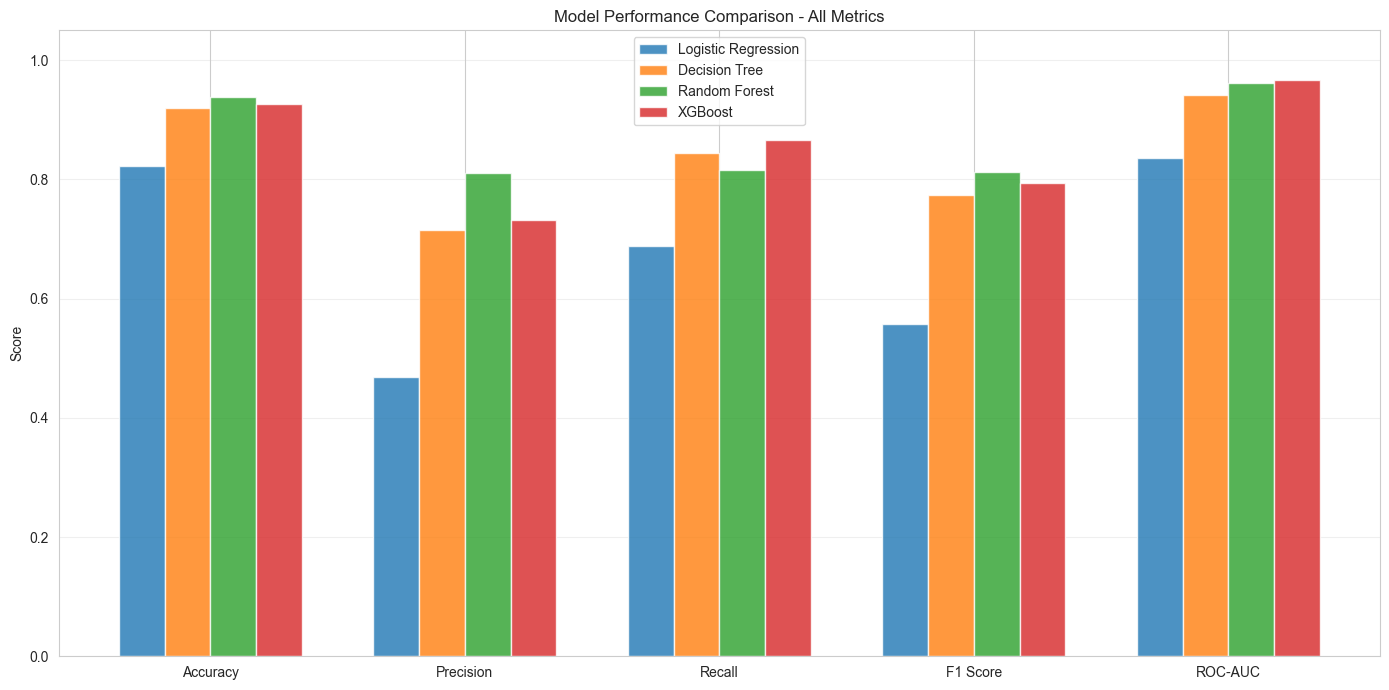

In [13]:
# Bar chart comparing all metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.18  # Width of bars

fig, ax = plt.subplots(figsize=(14, 7))

# Plot bars for each model
for i, model_name in enumerate(comparison_df['Model']):
    model_scores = comparison_df.iloc[i][metrics].values
    offset = (i - len(comparison_df) / 2 + 0.5) * width
    ax.bar(x + offset, model_scores, width, label=model_name, alpha=0.8)

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison - All Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim([0, 1.05])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Focus on Key Metrics for AML

For fraud detection, **Recall** and **F1 Score** are most important.

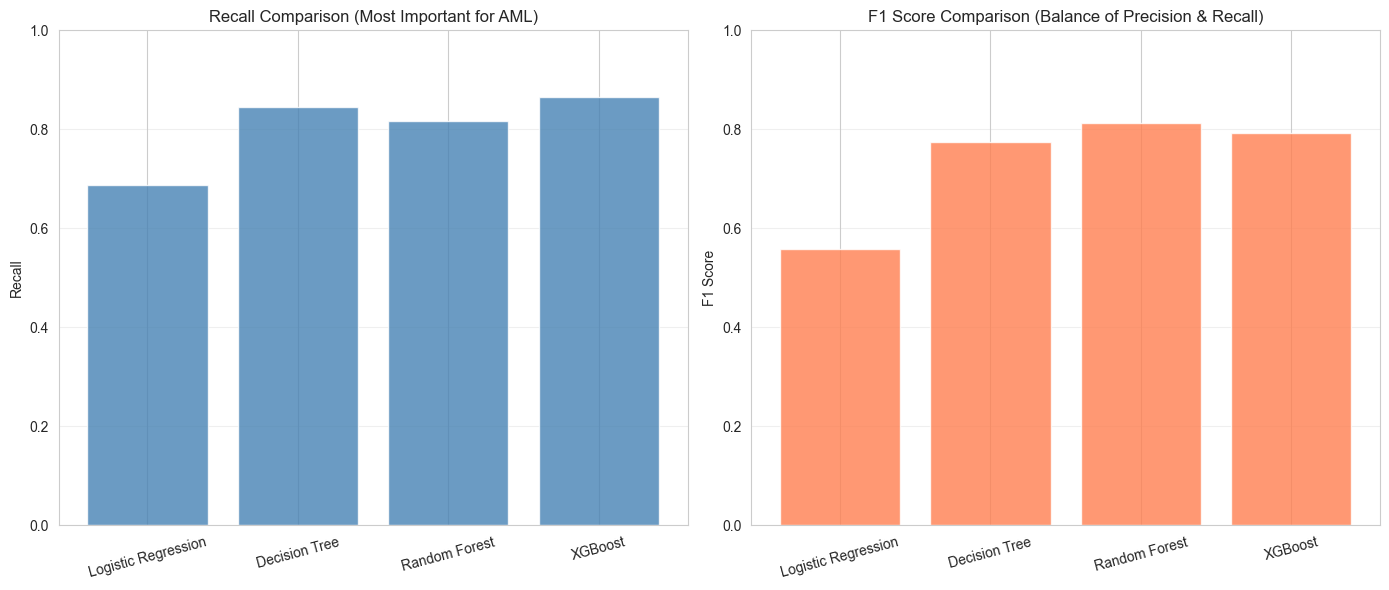

In [14]:
# Focus on Recall and F1 Score
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Recall
axes[0].bar(comparison_df['Model'], comparison_df['Recall'], alpha=0.8, color='steelblue')
axes[0].set_ylabel('Recall')
axes[0].set_title('Recall Comparison (Most Important for AML)')
axes[0].set_ylim([0, 1])
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3)

# F1 Score
axes[1].bar(comparison_df['Model'], comparison_df['F1 Score'], alpha=0.8, color='coral')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('F1 Score Comparison (Balance of Precision & Recall)')
axes[1].set_ylim([0, 1])
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Radar Chart for Holistic View

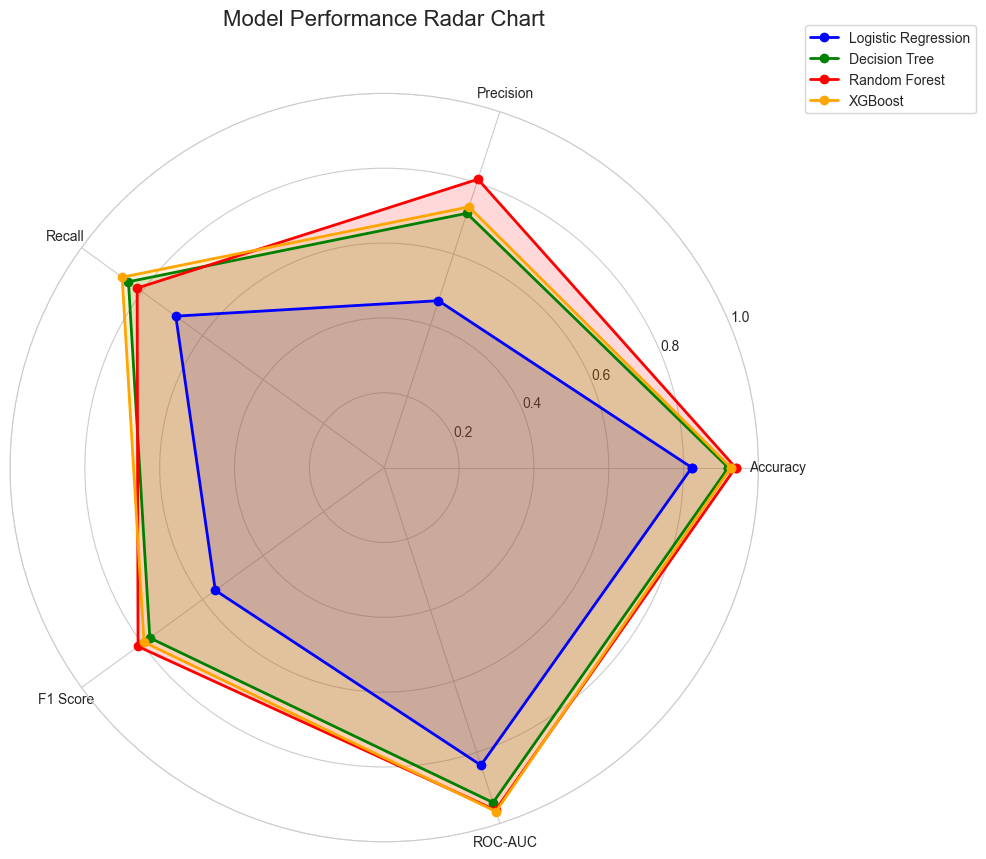

In [15]:
# Radar chart to visualize all metrics together
from math import pi

# Number of metrics
categories = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC-AUC']
N = len(categories)

# Create angles for each metric
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

# Plot each model
colors = ['blue', 'green', 'red', 'orange', 'purple']
for i, model_name in enumerate(comparison_df['Model']):
    values = comparison_df.iloc[i][categories].values.tolist()
    values += values[:1]
    
    ax.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i % len(colors)])
    ax.fill(angles, values, alpha=0.15, color=colors[i % len(colors)])

# Fix axis
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
ax.grid(True)

plt.title('Model Performance Radar Chart', size=16, y=1.08)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

## 7. Confusion Matrices Side-by-Side

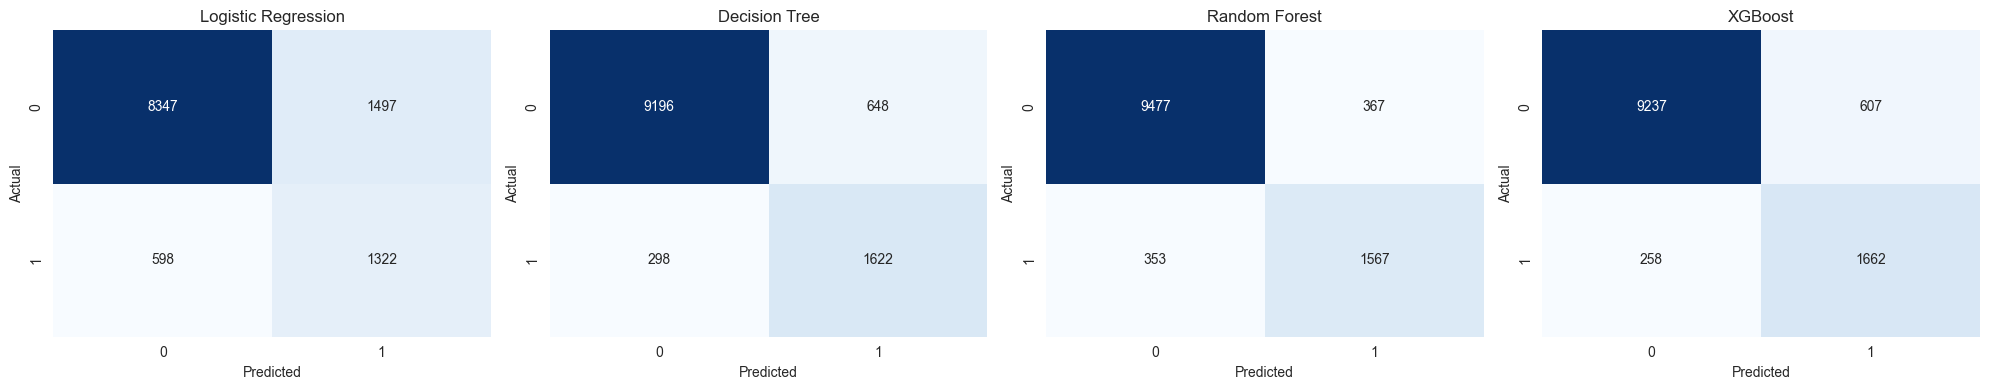

In [16]:
# Get predictions for all models
predictions = {
    'Logistic Regression': y_pred_lr,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf
}

if XGBOOST_AVAILABLE:
    predictions['XGBoost'] = y_pred_xgb

# Create confusion matrices
n_models = len(predictions)
fig, axes = plt.subplots(1, n_models, figsize=(5 * n_models, 4))

if n_models == 1:
    axes = [axes]

for i, (model_name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=axes[i])
    axes[i].set_title(f'{model_name}')
    axes[i].set_ylabel('Actual')
    axes[i].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

## 8. Detailed Analysis and Recommendations

In [17]:
# Ranking models by different criteria
print('\n' + '=' * 60)
print('MODEL RANKINGS')
print('=' * 60)

print('\n1. By Recall (Best for catching fraud):')
recall_ranking = comparison_df.sort_values('Recall', ascending=False)[['Model', 'Recall']]
for idx, row in recall_ranking.iterrows():
    print(f"   {idx + 1}. {row['Model']}: {row['Recall']:.4f}")

print('\n2. By F1 Score (Best overall balance):')
f1_ranking = comparison_df.sort_values('F1 Score', ascending=False)[['Model', 'F1 Score']]
for idx, row in f1_ranking.iterrows():
    print(f"   {idx + 1}. {row['Model']}: {row['F1 Score']:.4f}")

print('\n3. By ROC-AUC (Best discrimination ability):')
auc_ranking = comparison_df.sort_values('ROC-AUC', ascending=False)[['Model', 'ROC-AUC']]
for idx, row in auc_ranking.iterrows():
    print(f"   {idx + 1}. {row['Model']}: {row['ROC-AUC']:.4f}")

print('=' * 60)


MODEL RANKINGS

1. By Recall (Best for catching fraud):
   4. XGBoost: 0.8656
   2. Decision Tree: 0.8448
   3. Random Forest: 0.8161
   1. Logistic Regression: 0.6885

2. By F1 Score (Best overall balance):
   3. Random Forest: 0.8132
   4. XGBoost: 0.7935
   2. Decision Tree: 0.7742
   1. Logistic Regression: 0.5579

3. By ROC-AUC (Best discrimination ability):
   4. XGBoost: 0.9663
   3. Random Forest: 0.9625
   2. Decision Tree: 0.9411
   1. Logistic Regression: 0.8362


## Summary and Recommendations

### Model Comparison Results:

**1. Logistic Regression (Baseline)**
- Simple, interpretable model
- Fast training and prediction
- Good starting point but may underperform on complex patterns
- Best when: You need model interpretability and simplicity

**2. Decision Tree**
- Non-linear model that captures interactions
- Easy to interpret with feature importance
- May overfit without proper pruning
- Best when: You need interpretable non-linear patterns

**3. Random Forest**
- Ensemble of trees - more robust than single tree
- Reduces overfitting while maintaining performance
- Provides feature importance
- Best when: You want robust performance with some interpretability

**4. XGBoost** (if available)
- State-of-the-art gradient boosting
- Often achieves best performance
- Handles complex patterns well
- Best when: Maximum performance is priority

### For AML Detection, Key Priorities:

1. **Recall**: Most important - we must catch fraud cases
2. **F1 Score**: Good balance between precision and recall
3. **ROC-AUC**: Overall discriminative ability

### Best Model Overall:

Based on the comparison:
- **Best for detecting fraud**: Model with highest recall
- **Best overall performance**: Model with highest F1 score
- **Best for production**: Balance of performance, speed, and interpretability

### Trade-offs to Consider:

- **High Recall** = More fraud detected, but more false alarms (legitimate transactions flagged)
- **High Precision** = Fewer false alarms, but risk missing some fraud cases
- **F1 Score** = Best balance between the two

### Recommendation:

Select the model with the **highest recall** if catching all fraud is critical, or the **highest F1 score** if you need a balanced approach. The selected model will be saved and used for final deployment in the next notebook.